In [8]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, ensemble
from prophet import Prophet
import matplotlib.pyplot as plt
import os
import glob

In [9]:
def get_rolling_median_filtered(signal, window_size=3, threshold=1):
    """
    Input: 
        signals: List of numbers 
        window_size: Integer, window size that calculate median from
        threshold: the ratio of difference between calculate median and given 
                    value that will be considered as an outlier
    
    Output: List of numbers that represent the index of outlier
    """
    # result = pd.Series(signal).rolling(window_size).median().fillna(method='bfill') 
    result = list(signal)[0:window_size//2]
    for idx in range(len(signal)-window_size+1):
        result.append(np.median(signal[idx:idx+window_size]))
    result.extend(list(signal)[-1 * (window_size//2) : ])

    
    difference = np.abs(result - signal) / (signal+1)
    outlier = difference > threshold
    outlier_index = outlier[outlier].index.values
    return list(outlier_index)

In [10]:
def cart_outlier(signal, fraction = 0.05):
    """
    Input: 
        signals: List of numbers
        fraction: Float, the portion of data that we will be considered as outliers
    
    Output: List of numbers that represent the index of outlier
    """
    scaler = preprocessing.StandardScaler()
    signal_scaled = scaler.fit_transform(np.array(signal).reshape(-1, 1))
    data = pd.DataFrame(signal_scaled)
    model = ensemble.IsolationForest(contamination=fraction)
    model.fit(data)
    outlier = model.predict(data)
    outlier_index = np.where(outlier == -1)[0]
    return list(outlier_index)

In [11]:
def prophet_prediction(signal, date):
    """
    Input:
        signals: List of numbers
        date: List of strings, ex: ['1/22/20', '1/23/20', ...]
    
    Output: List of numbers that represent the index of outlier
    """
    model = Prophet(daily_seasonality = False, yearly_seasonality = False, 
                    weekly_seasonality = False,
                    seasonality_mode = 'additive')
    df = pd.DataFrame(list(zip(date, signal)), columns=['ds','y'])
    model.fit(df)
    forecast = model.predict(df)
    forecast['fact'] = df['y'].reset_index(drop = True)
    forecast['anomaly'] = 0
    forecast.loc[forecast['fact'] > forecast['yhat_upper'], 'anomaly'] = 1
    forecast.loc[forecast['fact'] < forecast['yhat_lower'], 'anomaly'] = -1
    outlier_index = forecast[forecast['anomaly'] != 0].index
    return list(outlier_index)

In [12]:
def plot_figure(ori, remove, title):
    fig, ax = plt.subplots()
    ax.plot(ori, label="raw data")
    ax.plot(remove, label="remove outlier data")
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Cases')
    plt.legend()
    return fig

In [13]:
### the date that you want to start detect the outlier
Date = '1/22/20'

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

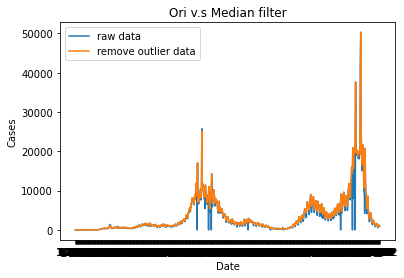

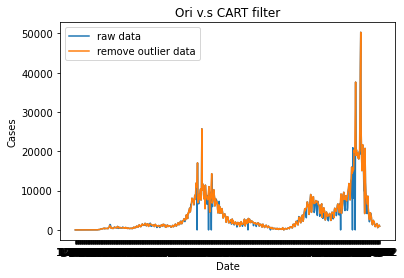

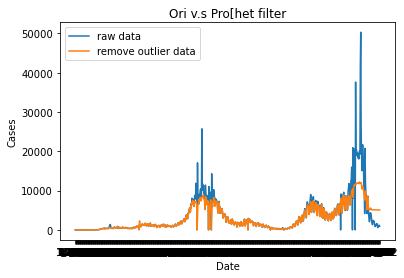

In [15]:
for file in glob.glob('../daily_cases/new_daily_states_county/*.csv'):
        state = file.split('/')[-1].split('.csv')[0].split('_')[-1]
        ori_data = pd.read_csv(file)
        remain_part = ori_data.iloc[:, :ori_data.columns.get_loc(Date)]
        detect_part = ori_data.loc[:, Date:]
        ori_cases = detect_part.sum()
        date_column = detect_part.columns
        
        ### Use median filtering to detect outlier
        for row in range(len(detect_part)):
            series = detect_part.iloc[row, :]
            rolling_median_outlier_idx = get_rolling_median_filtered(series, 7, 0.8)
            series[rolling_median_outlier_idx] = np.nan
            detect_part.iloc[row,:] = series.astype(float).interpolate().astype(int)
        median_result = pd.concat([remain_part, detect_part], axis=1, join="inner")
        median_cases = median_result.loc[:, date_column].sum()
        fig = plot_figure(ori_cases, median_cases, "Ori v.s Median filter")
        img_name = '../remove_outlier_cases/median_filter/Raw_vs_remove_image/' + state + '.png'
        file_name = '../remove_outlier_cases/median_filter/remove_outlier_' + state + '.csv'
        if os.path.exists(img_name):
            os.remove(img_name)
        fig.savefig(img_name)
        if os.path.exists(file_name):
            os.remove(file_name)
        median_result.to_csv(file_name, index = False)
        
        
        ### Use CART to detect outlier
        detect_part = ori_data.loc[:, Date:]
        for row in range(len(detect_part)):
            series = detect_part.iloc[row, :]
            cart_outlier_idx = cart_outlier(series)
            series[rolling_median_outlier_idx] = np.nan
            detect_part.iloc[row,:] = series.astype(float).interpolate().astype(int)
        cart_result = pd.concat([remain_part, detect_part], axis=1, join="inner")
        cart_cases = cart_result.loc[:, date_column].sum()
        fig = plot_figure(ori_cases, cart_cases, "Ori v.s CART filter")
        img_name = '../remove_outlier_cases/CART/Raw_vs_remove_image/' + state + '.png'
        file_name = '../remove_outlier_cases/CART/remove_outlier_' + state + '.csv' 
        if os.path.exists(img_name):
            os.remove(img_name)
        fig.savefig(img_name)
        if os.path.exists(file_name):
            os.remove(file_name)
        median_result.to_csv(file_name, index = False)
        
    
        ### Use Prophet to detect outlier
        detect_part = ori_data.loc[:, Date:]
        for row in range(len(detect_part)):
            series = detect_part.iloc[row, :]
            prophet_outlier_idx = prophet_prediction(series, date_column)
            series[prophet_outlier_idx] = np.nan
            detect_part.iloc[row,:] = series.astype(float).interpolate().astype(int)
        prophet_result = pd.concat([remain_part, detect_part], axis=1, join="inner")
        prophet_cases = prophet_result.loc[:, date_column].sum()
        fig = plot_figure(ori_cases, prophet_cases, "Ori v.s Pro[het filter")
        img_name = '../remove_outlier_cases/Prophet/Raw_vs_remove_image/' + state + '.png'
        file_name = '../remove_outlier_cases/Prophet/remove_outlier_' + state + '.csv'
        if os.path.exists(img_name):
            os.remove(img_name)
        fig.savefig(img_name)
        if os.path.exists(file_name):
            os.remove(file_name)
        median_result.to_csv(file_name, index = False)
        